In [1]:
!pip install arabic_reshaper

# Importing Libraries

In [2]:

import pandas as pd  # Data manipulation library
import numpy as np   # Numerical computation library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns   # Statistical data visualization library
from wordcloud import WordCloud  # Generating word clouds
from arabic_reshaper import arabic_reshaper  # Reshaping Arabic text for better display
from bidi.algorithm import get_display  # Reshaping Arabic text for better display

import torch  # PyTorch deep learning framework
import wandb  # Weights & Biases for experiment tracking
from sklearn.model_selection import train_test_split  # Splitting dataset into train and test sets
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Hugging Face Transformers library for NLP
from torch.utils.data import TensorDataset  # PyTorch data handling utilities
from transformers import Trainer, TrainingArguments  # Hugging Face Transformers library for model training
from sklearn.metrics import accuracy_score  # Evaluation metric for classification tasks

from kaggle_secrets import UserSecretsClient  # Kaggle-specific library for accessing user secrets

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set maximum column width for Pandas display
pd.set_option('display.max_colwidth', None)
# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)


2024-04-29 23:04:46.449821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 23:04:46.449933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 23:04:46.589614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_csv("/kaggle/input/arabic-resturant-reviews/Arabic_resturant_reviews.csv")
data

,review,label
0,المطعم يجنن والاكل تحفة,1
1,أنصح بزيارة المطعم ده بجد، الأكل عندهم لذيذ والخدمة متميزة جداً.,1
2,لقد كانت تجربة سيئة، الطعام غير مقبول والخدمة سيئة للغاية.,0
3,الطاقم غير احترافي على الإطلاق، والخدمة بطيئة وغير فعّالة.,0
4,الطعام في هذا المطعم كان سيئًا للغاية والخدمة كانت سيئة أيضًا، لم يكن هناك أي اهتمام بتجربة العملاء.,0
...,...,...
795,خدمة ممتازة وأطباق شهية، لا يمكنني الانتظار للعودة.,1
796,كانت تجربتي في هذا المطعم فاشلة، الطعام كان سيئًا للغاية ولم يكن طازجًا على الإطلاق، وكانت الخدمة بطيئة وغير احترافية. لن أعود هنا مرة أخرى بالتأكيد.,0
797,لقد استمتعت بكل لحظة في هذا المطعم، الطعام لذيذ والخدمة متفانية والأجواء رائعة، لا يمكنني الانتظار للعودة.,1
798,لن أعود إلى هذا المطعم مرة أخرى، الطعام غير مرضي والخدمة سيئة.,0


# Distribution of Classes

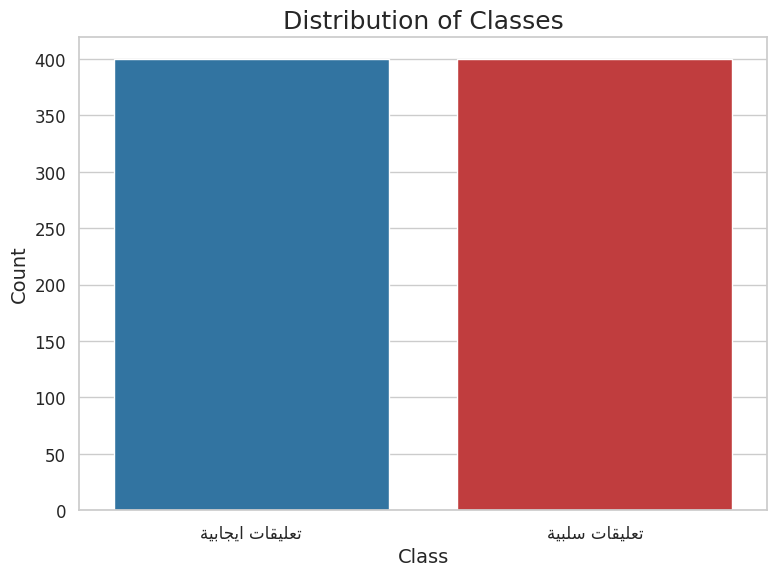

In [4]:
positive = get_display(arabic_reshaper.reshape('تعليقات ايجابية'))
negative = get_display(arabic_reshaper.reshape('تعليقات سلبية'))
                       
# Your class distribution data
class_distribution = data['label'].value_counts()

# Define mapping from numerical labels to Arabic strings
label_mapping = {1: positive, 0: negative}

# Map numerical labels to Arabic strings
class_distribution.index = class_distribution.index.map(label_mapping)

# Plotting
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["#1f77b4", "#d62728"])
plt.title('Distribution of Classes', fontsize=18)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Text length distribution

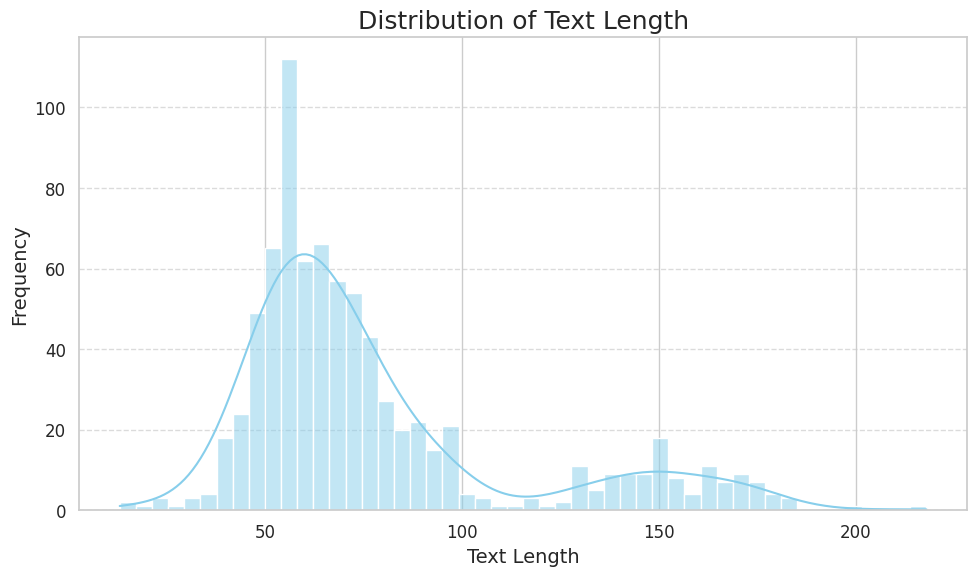

In [5]:
# Calculate text lengths
data['text_length'] = data['review'].apply(len)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(data['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Text Length', fontsize=18)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Generate word clouds for each class

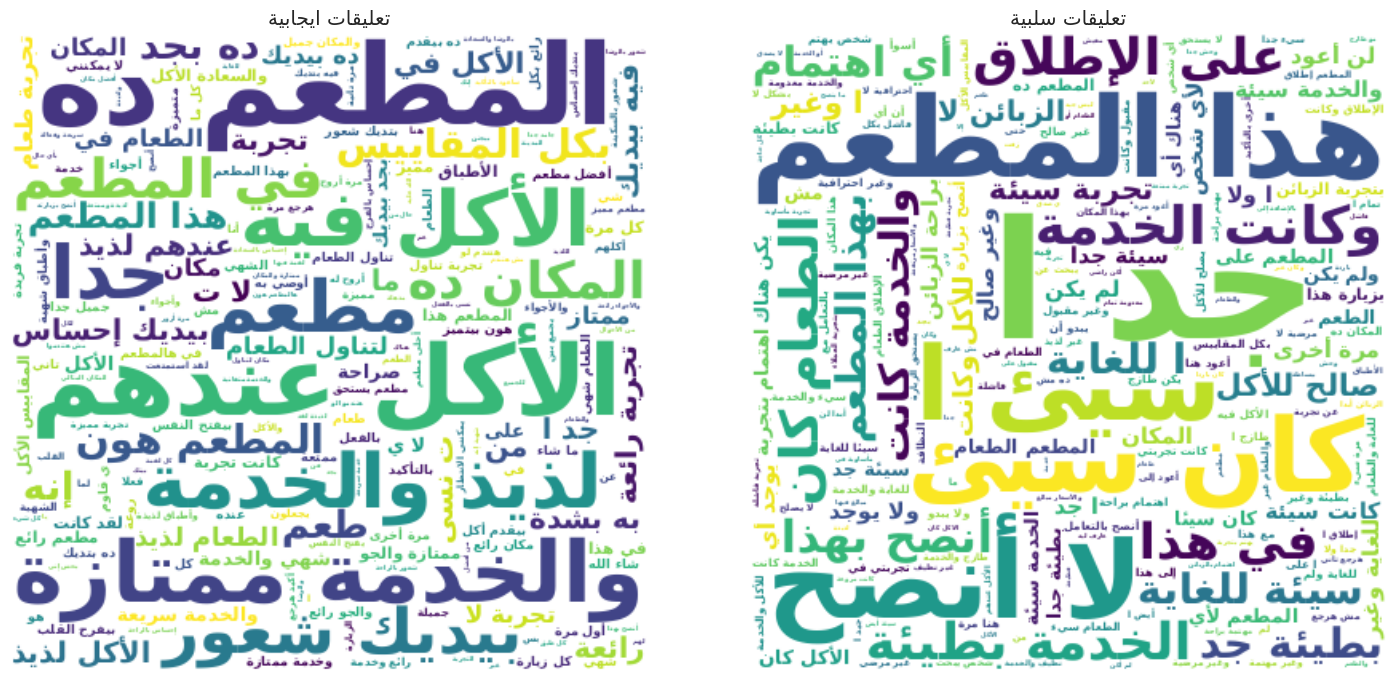

In [6]:

classes = data['label'].unique()
fig, axs = plt.subplots(1, len(classes), figsize=(15, 7))

for i, label in enumerate(classes):
    # Filter reviews based on class label
    reviews = ' '.join(data[data['label'] == label]['review'])
    
    # Generate word cloud
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
                          background_color='white',
                          width=400,
                          height=400,
                          max_words=200,
                          contour_color='steelblue').generate(reviews)

    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    title = negative if label == 0 else positive
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Load  and Finetune Pre-trained Arabert Model

In [7]:
secret_label = 'API_KEY'
API_KEY = UserSecretsClient().get_secret(secret_label)

wandb.login(key=API_KEY)


reviews = data['review'].values
labels = data['label'].values

# Step 2: Load Pre-trained Arabert Model
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02')
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv02', num_labels=2)

# Step 3: Define Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 4: Prepare Dataset
max_length = 256

# Tokenize and encode the reviews
encoded_reviews = tokenizer(reviews.tolist(), 
                            padding=True, 
                            truncation=True, 
                            max_length=max_length, 
                            return_tensors='pt')

# Create TensorDataset
dataset = TensorDataset(encoded_reviews['input_ids'], 
                        encoded_reviews['attention_mask'], 
                        torch.tensor(labels))

# Split dataset into training and validation sets
test_size = 0.2
train_dataset, val_dataset = train_test_split(dataset, test_size=test_size, random_state=42)

# Step 5: Train the Model
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Define evaluation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Custom data collator to handle batch processing
class MyDataCollator:
    def __call__(self, features):
        input_ids = [feature[0] for feature in features]
        attention_masks = [feature[1] for feature in features]
        labels = [feature[2] for feature in features]
        return {
            'input_ids': torch.stack(input_ids, dim=0),
            'attention_mask': torch.stack(attention_masks, dim=0),
            'labels': torch.tensor(labels)
        }

# Create Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # evaluation metrics
    data_collator=MyDataCollator()       # custom data collator
)

# Train the model
trainer.train()

# Save the trained model
model_path = "./trained_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: moazeldsokys9. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240429_230507-jryeq276
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fast-oath-10
wandb: ⭐️ View project at https://wandb.ai/moazeldsokys9/huggingface
wandb: 🚀 View run at https://wandb.ai/moazeldsokys9/huggingface/runs/jryeq276


Epoch,Training Loss,Validation Loss,Accuracy
1,0.661000,0.613556,0.643750
2,0.500400,0.391431,0.937500
3,0.261100,0.167172,0.993750
4,0.103200,0.062412,0.993750
5,0.034300,0.027388,0.993750


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

In [8]:

# Load the saved model and tokenizer
model_path = "./trained_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Define the device to run inference on (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

test_reviews = [
    "المطعم ما عجبني، الطعم مو حلو والخدمة كانت سيئة جداً، والموظفين ما كانوا محترمين. الأسعار غالية مقارنة بالجودة. ما بنصح فيه.",
    "المطعم يجنن والاكل تحفة",
]

max_length = 256  # Define max length for tokenization

for review in test_reviews:
    # Step 1: Tokenization
    encoded_text = tokenizer(review, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

    # Move input tensors to the appropriate device
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    # Step 2: Inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Step 3: Prediction with probabilities
    probs = torch.softmax(outputs.logits, dim=-1)
    probs = probs.squeeze().cpu().numpy()  # Convert to numpy array and remove the batch dimension

    # Map predicted class index to label
    label_map = {0: 'سلبي', 1: 'إيجابي'}

    # Get predicted class
    predicted_class_index = torch.argmax(torch.tensor(probs)).item()  # Convert probs to tensor before using argmax
    predicted_class = label_map[predicted_class_index]

    print(review)
    # Print predicted class
    print("التصنيف المتوقع:", predicted_class)

    # Print probabilities for each class
    for i, label in label_map.items():
        print(f"احتمالية {label}: {probs[i]:.2f}")
    print("")


المطعم ما عجبني، الطعم مو حلو والخدمة كانت سيئة جداً، والموظفين ما كانوا محترمين. الأسعار غالية مقارنة بالجودة. ما بنصح فيه.
التصنيف المتوقع: سلبي
احتمالية سلبي: 0.99
احتمالية إيجابي: 0.01

المطعم يجنن والاكل تحفة
التصنيف المتوقع: إيجابي
احتمالية سلبي: 0.06
احتمالية إيجابي: 0.94



In [9]:
import zipfile
import os

# Directory containing the trained model and tokenizer
model_path = "./trained_model"

# Zip file name
zip_file_name = "trained_model.zip"

# Zip the directory
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(model_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(model_path, '..')))

print("Model zipped successfully.")

Model zipped successfully.
